In [1]:
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np 
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn.calibration import calibration_curve

https://indico.ict.inaf.it/event/794/sessions/1653/#20210909

In [2]:
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['font.family'] = 'Helvetica'
sns.set_context("paper", font_scale=1.2)

In [3]:
# ar data with flares
data_ar = pd.read_csv("AR_flare_ml_23_24.csv")

# evolution data
data_ar_evol = pd.read_csv("AR_flare_ml_23_24_evol.csv")
# row_has_NaN = data_ar_evol.isnull().any(axis=1)
# data_ar_evol = data_ar_evol[~row_has_NaN]

In [4]:
data_ar["AR issue_date"].head()

0    1996-08-01 00:30
1    1996-08-02 00:30
2    1996-08-03 00:30
3    1996-08-04 00:30
4    1996-08-05 00:30
Name: AR issue_date, dtype: object

In [5]:
data_ar.head(3)

,AR issue_date,noaa_ar,Carrington_long,AREA,McIntosh,Longitude_extent,Latitude,Longitude,No_sunspots,MAGTYPE,LOCATION,C,M,X,C+,M+,X+
0,1996-08-01 00:30,7981,258,410,ESO,12,-9,-22,24.0,BETA-GAMMA,S09E22,0.0,0.0,0.0,0.0,0.0,0.0
1,1996-08-02 00:30,7981,257,300,ESI,12,-9,-9,22.0,BETA-GAMMA,S09E09,0.0,0.0,0.0,0.0,0.0,0.0
2,1996-08-03 00:30,7981,258,320,ESO,12,-9,5,24.0,BETA-GAMMA,S09W05,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data_ar_evol["zurich"] = data_ar_evol["McIntosh"].map(lambda x: x[0])
data_ar_evol["penumbral"] = data_ar_evol["McIntosh"].map(lambda x: x[1])
data_ar_evol["compact"] = data_ar_evol["McIntosh"].map(lambda x: x[2])

data_ar["zurich"] = data_ar["McIntosh"].map(lambda x: x[0])
data_ar["penumbral"] = data_ar["McIntosh"].map(lambda x: x[1])
data_ar["compact"] = data_ar["McIntosh"].map(lambda x: x[2])

In [7]:
ar_w_flare = data_ar[data_ar["C+"]>0]
ar_no_flare = data_ar[data_ar["C+"]==0]

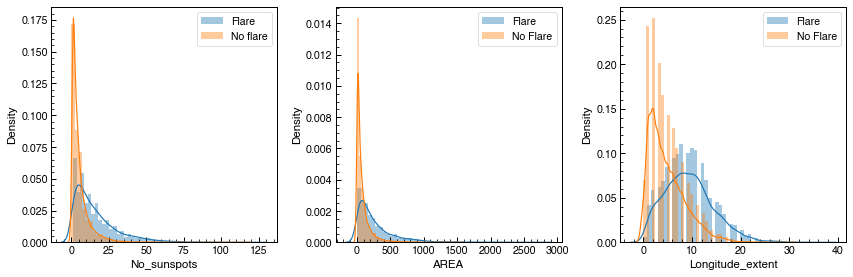

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.distplot(ar_w_flare["No_sunspots"], ax=ax[0], label="Flare")
sns.distplot(ar_no_flare["No_sunspots"], ax=ax[0], label="No flare")

sns.distplot(ar_w_flare["AREA"], ax=ax[1], label="Flare")
sns.distplot(ar_no_flare["AREA"], ax=ax[1], label="No Flare")

sns.distplot(ar_w_flare["Longitude_extent"], ax=ax[2], label="Flare")
sns.distplot(ar_no_flare["Longitude_extent"], ax=ax[2], label="No Flare")

for a in ax:
    a.tick_params(which="both", direction="in")
    a.legend(loc="upper right")
    
plt.tight_layout()

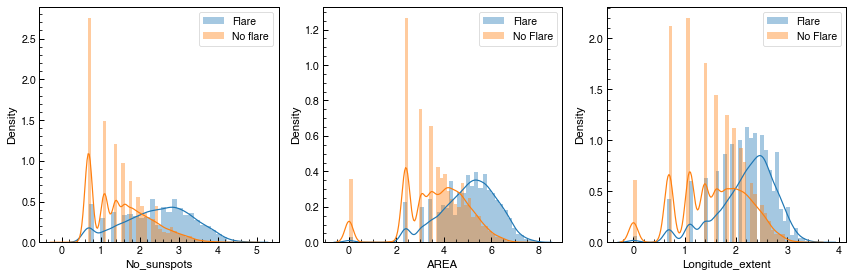

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.distplot(np.log1p(ar_w_flare["No_sunspots"]), ax=ax[0], label="Flare")
sns.distplot(np.log1p(ar_no_flare["No_sunspots"]), ax=ax[0], label="No flare")

sns.distplot(np.log1p(ar_w_flare["AREA"]), ax=ax[1], label="Flare")
sns.distplot(np.log1p(ar_no_flare["AREA"]), ax=ax[1], label="No Flare")

sns.distplot(np.log1p(ar_w_flare["Longitude_extent"]), ax=ax[2], label="Flare")
sns.distplot(np.log1p(ar_no_flare["Longitude_extent"]), ax=ax[2], label="No Flare")

for a in ax:
    a.tick_params(which="both", direction="in")
    a.legend(loc="upper right")
    
plt.tight_layout()

Text(0, 0.5, 'Normalized % of cases')

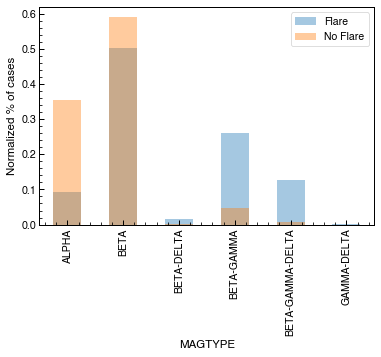

In [10]:
fig, ax = plt.subplots(1)
((ar_w_flare.groupby(["MAGTYPE"])["C"].count())/len(ar_w_flare)).plot.bar(ax=ax, 
                                                                          alpha=0.4, label="Flare")
((ar_no_flare.groupby(["MAGTYPE"])["C"].count())/len(ar_no_flare)).plot.bar(ax=ax, color="tab:orange", 
                                                                            alpha=0.4, label="No Flare")
ax.legend()
ax.set_ylabel("Normalized % of cases")

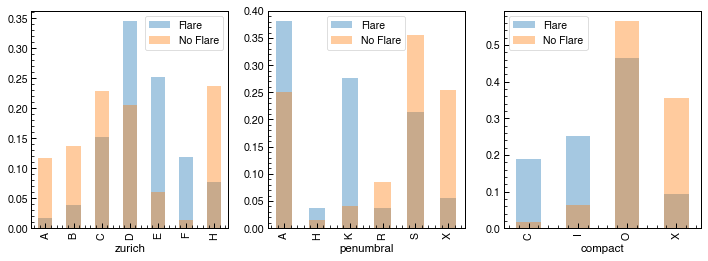

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
((ar_w_flare.groupby(["zurich"])["C"].count())/len(ar_w_flare)).plot.bar(ax=ax[0], 
                                                                          alpha=0.4, label="Flare")
((ar_no_flare.groupby(["zurich"])["C"].count())/len(ar_no_flare)).plot.bar(ax=ax[0], color="tab:orange",
                                                                           alpha=0.4, label="No Flare")

((ar_w_flare.groupby(["penumbral"])["C"].count())/len(ar_w_flare)).plot.bar(ax=ax[1], 
                                                                          alpha=0.4, label="Flare")
((ar_no_flare.groupby(["penumbral"])["C"].count())/len(ar_no_flare)).plot.bar(ax=ax[1], color="tab:orange",
                                                                           alpha=0.4, label="No Flare")


((ar_w_flare.groupby(["compact"])["C"].count())/len(ar_w_flare)).plot.bar(ax=ax[2], 
                                                                          alpha=0.4, label="Flare")
((ar_no_flare.groupby(["compact"])["C"].count())/len(ar_no_flare)).plot.bar(ax=ax[2], color="tab:orange",
                                                                           alpha=0.4, label="No Flare")


for a in ax:
    a.legend()


Text(0, 0.5, 'Normalized % of cases')

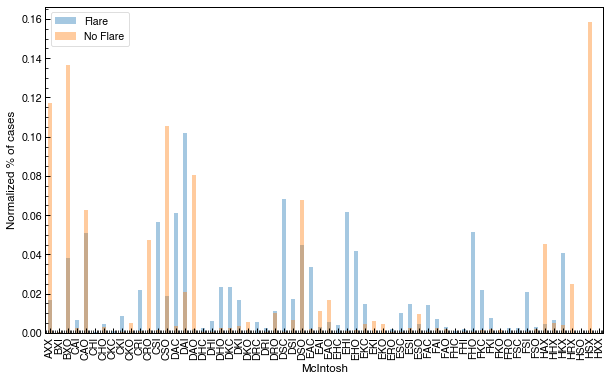

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
((ar_w_flare.groupby(["McIntosh"])["C"].count())/len(ar_w_flare)).plot.bar(ax=ax, 
                                                                          alpha=0.4, label="Flare")
((ar_no_flare.groupby(["McIntosh"])["C"].count())/len(ar_no_flare)).plot.bar(ax=ax, color="tab:orange", 
                                                                            alpha=0.4, label="No Flare")
ax.legend()
ax.set_ylabel("Normalized % of cases")

## Lets test some ML approach

In [13]:
data_ar.head(3)

,AR issue_date,noaa_ar,Carrington_long,AREA,McIntosh,Longitude_extent,Latitude,Longitude,No_sunspots,MAGTYPE,LOCATION,C,M,X,C+,M+,X+,zurich,penumbral,compact
0,1996-08-01 00:30,7981,258,410,ESO,12,-9,-22,24.0,BETA-GAMMA,S09E22,0.0,0.0,0.0,0.0,0.0,0.0,E,S,O
1,1996-08-02 00:30,7981,257,300,ESI,12,-9,-9,22.0,BETA-GAMMA,S09E09,0.0,0.0,0.0,0.0,0.0,0.0,E,S,I
2,1996-08-03 00:30,7981,258,320,ESO,12,-9,5,24.0,BETA-GAMMA,S09W05,0.0,0.0,0.0,0.0,0.0,0.0,E,S,O


## Features to focus on 

As inputs to our model we will use specific features that will help predict if an active region will flare.

These are:

* **Longitudinal_extent** (numerical)
* **AREA** (numerical)
* **No_sunspots** (numerical)
* **McIntosh** (categorical)
* **MagType** (categorical)

Further on we can in more features such as if a past AR flared or not etc. 

For these features, theres a number of preprocessing steps that is required. Namely, for we need a method for dealing with the categorical data, and then think about scaling the numerical data.

In [14]:
le1 = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()



In [15]:
data_ar_evol["MAGTYPE_ML"] = le1.fit_transform(data_ar_evol["MAGTYPE"])
data_ar_evol["McIntosh_ML"] = le2.fit_transform(data_ar_evol["McIntosh"])


data_ar_evol["z"] = preprocessing.LabelEncoder().fit_transform(data_ar_evol["zurich"])
data_ar_evol["p"] = preprocessing.LabelEncoder().fit_transform(data_ar_evol["penumbral"])
data_ar_evol["c"] = preprocessing.LabelEncoder().fit_transform(data_ar_evol["compact"])

In [16]:
scaler = preprocessing.StandardScaler().fit(data_ar_evol[["Longitude_extent", "AREA", "No_sunspots"]])

In [17]:
data_ar_evol[["Longitude_extent_ml", "AREA_ml", "No_subspots_ml"]] = scaler.transform(data_ar_evol[["Longitude_extent", "AREA", "No_sunspots"]])

In [18]:
data_ar_evol.head(3)

,AR issue_date,noaa_ar,Carrington_long,AREA,McIntosh,Longitude_extent,Latitude,Longitude,No_sunspots,MAGTYPE,...,penumbral,compact,MAGTYPE_ML,McIntosh_ML,z,p,c,Longitude_extent_ml,AREA_ml,No_subspots_ml
0,1996-08-01 00:30,7981,258,410,ESO,12,-9,-22,24.0,BETA-GAMMA,...,S,O,3,42,4,4,2,1.442773,1.595336,1.776528
1,1996-08-02 00:30,7981,257,300,ESI,12,-9,-9,22.0,BETA-GAMMA,...,S,I,3,41,4,4,1,1.442773,0.994936,1.563273
2,1996-08-03 00:30,7981,258,320,ESO,12,-9,5,24.0,BETA-GAMMA,...,S,O,3,42,4,4,2,1.442773,1.104100,1.776528


In [19]:
data_ar_evol["pre_flare"].replace(np.nan, 0, inplace=True)

In [20]:
col_features = ["Longitude_extent_ml", "AREA_ml", "No_subspots_ml", "MAGTYPE_ML", "McIntosh_ML", "z", "p", "c", 
                "pre_flare"]
#col_features = ["MAGTYPE_ML", "McIntosh_ML"]
features = data_ar_evol[col_features]

target = data_ar_evol["C+"].map(lambda x: 1 if x>0 else 0)


### Lets now split this data into training/testing 

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(features.values, target.values, test_size=0.2, shuffle=False)

In [22]:
print("% flares in train data is {:f}".format(100*np.sum(Y_train)/len(Y_train)))
print("% flares in test data is {:f}".format(100*np.sum(Y_test)/len(Y_test)))

% flares in train data is 17.939728
% flares in test data is 22.031623


In [23]:
climatology = np.mean(Y_test)

In [24]:
? np.full

## Now lets choose some models and perform some ML 

In [27]:
mdl = RandomForestClassifier()
mdl.fit(X_train, Y_train)

RandomForestClassifier()

In [28]:
prediction = mdl.predict(X_test)

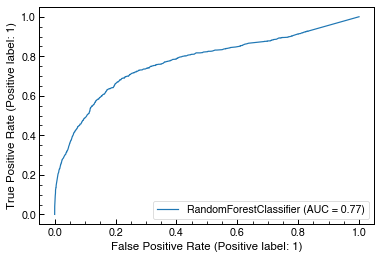

In [29]:
metrics.plot_roc_curve(mdl, X_test, Y_test)

In [30]:
tn, fp, fn, tp = metrics.confusion_matrix(Y_test, prediction).ravel()

In [31]:
metrics.confusion_matrix(Y_test, prediction)

array([[4881,  346],
       [ 860,  617]])

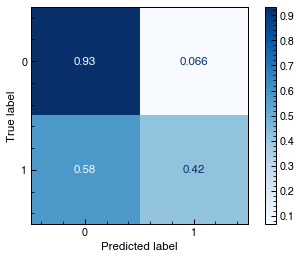

In [32]:
metrics.plot_confusion_matrix(mdl, X_test, Y_test, normalize='true', cmap="Blues")

In [33]:
if hasattr(mdl, "predict_proba"):
    prob_pos = mdl.predict_proba(X_test)[:, 1]
#     prob_pos = 10**(mdl.predict_log_proba(X_test)[:,1])
else:  # use decision function
    prob_pos = mdl.decision_function(X_test)
    prob_pos = \
        (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

fraction_of_positives, mean_predicted_value = \
        calibration_curve(Y_test, prob_pos, n_bins=10)

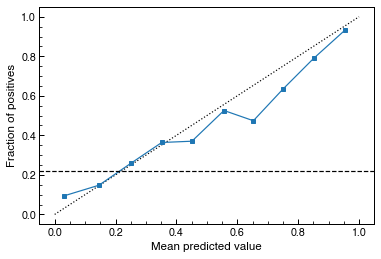

In [34]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax.plot(mean_predicted_value, fraction_of_positives, "s-")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")

plt.axhline(np.mean(Y_test), color="k", ls="dashed", label="Climatology")

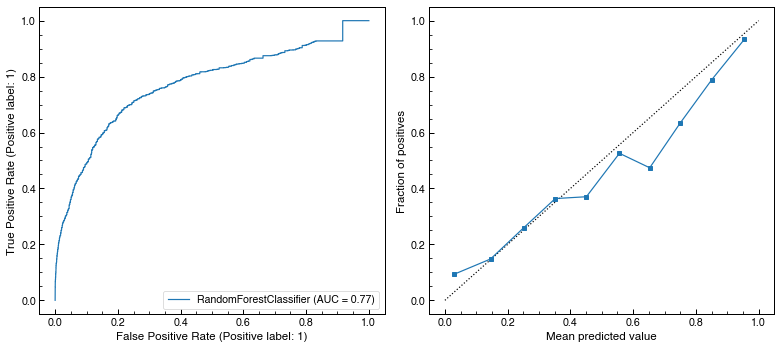

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))



metrics.plot_roc_curve(mdl, X_test, Y_test, drawstyle="steps-mid", ax=ax1)


ax2.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax2.plot(mean_predicted_value, fraction_of_positives, "s-")
ax2.set_ylabel("Fraction of positives")
ax2.set_xlabel("Mean predicted value")
plt.tight_layout()

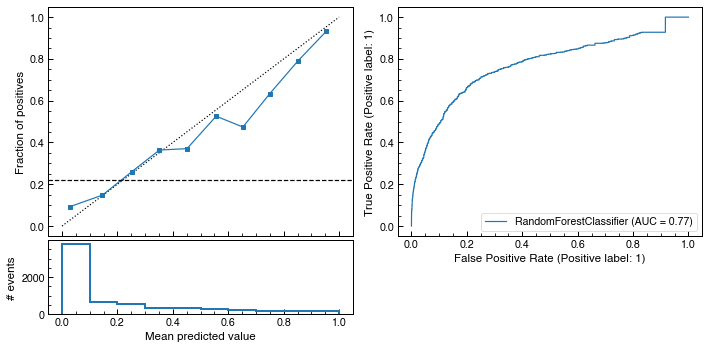

In [36]:
fig = plt.figure(figsize=(10, 5), constrained_layout=False)

gs1 = fig.add_gridspec(nrows=4, ncols=2)
ax1 = fig.add_subplot(gs1[:-1, :-1])
ax2 = fig.add_subplot(gs1[-1:, :1], sharex=ax1)
ax3 = fig.add_subplot(gs1[:-1, -1])

clim = np.mean(Y_test)

# Reliability plot
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.plot(mean_predicted_value, fraction_of_positives, "s-")
ax1.set_ylabel("Fraction of positives")
ax1.axhline(clim, ls="dashed", color="k")

# histogram of predicted probabilities
ax2.hist(prob_pos, range=(0, 1), bins=10, 
         histtype="step", lw=2)
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("# events")
# ROC curve
metrics.plot_roc_curve(mdl, X_test, Y_test, drawstyle="steps-mid", ax=ax3)
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig("test.png", facecolor="w", bbox_inches="tight", dpi=300)

In [34]:
def get_tss(Y_test, prediction):
    tn, fp, fn, tp = metrics.confusion_matrix(Y_test, prediction).ravel()
    
    TSS = (tp / (tp + fn)) - (fp / (fp + tn))
    return TSS

In [35]:
def get_bss(Y_test, prob_pos):
    bs = metrics.brier_score_loss(Y_test, prob_pos)
    bs_clim = np.mean(Y_test)
    BSS = 1 - bs/bs_clim
    return BSS
    

In [36]:
tss = get_tss(Y_test, prediction); print(tss)

0.3216299566375775


In [37]:
bss = get_bss(Y_test, prob_pos); print(bss)

0.2634471364187424


In [40]:
def plot_feature_importance(mdl, features, top=None, title="Feature importance"):
    """
    Function to plot the importance of features from a model. 
    
    Parameters
    ----------
    mdl : sklearn model that has been already fit
    features : `pd.DataFrame` of features. 
    top : `int`, optional, number of top features to plot.
          default is to plot all. 
    
    """
    
    if not hasattr(mdl, "feature_importances_"):
        print("{:s} doesn't have feature importance attribute".format(str(mdl)))
        return
    feature_importance = mdl.feature_importances_
    if top is not None:
        sorted_idx = np.argsort(feature_importance)[::-1][0:top]
    else:
        sorted_idx = np.argsort(feature_importance)[::-1]
    np.array(features.columns)[sorted_idx]
    
    pos = np.arange(0, sorted_idx.shape[0]*2, 2)
    
    fig = plt.figure(figsize=(10, 8))
    plt.barh(pos, feature_importance[sorted_idx], 2, align='center', edgecolor="k")
    plt.gca().invert_yaxis()
    plt.yticks(pos, np.array(features.columns)[sorted_idx])
    plt.title(title)

In [41]:
plot_feature_importance(mdl, features)

SVC() doesn't have feature importance attribute


## Lets try some regression ...

In [50]:
col_features = ["Longitude_extent_ml", "AREA_ml", "No_subspots_ml", "MAGTYPE_ML", "McIntosh_ML", "z", "p", "c", 
                "pre_flare"]
# col_features = ["MAGTYPE_ML", "McIntosh_ML"]
features = data_ar_evol[col_features]

target = data_ar_evol["C+"]

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(features.values, target.values, test_size=0.2, shuffle=False)

In [52]:
mdl = SVR()
mdl.fit(X_train, Y_train)

SVR()

In [53]:
pred = mdl.predict(X_test)

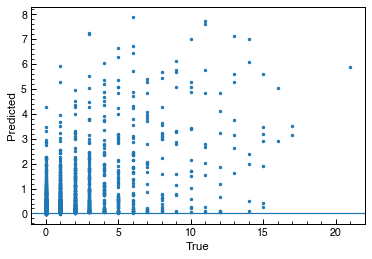

In [54]:
plt.plot(Y_test, pred, marker='.', ls='')
plt.xlabel("True")
plt.ylabel("Predicted")

plt.axhline(0)

In [55]:
Y_test_thresh = [0 if x==0 else 1 for x in Y_test]
pred_thresh = [0 if x<0.1 else 1 for x in pred]

In [56]:
get_tss(Y_test_thresh, pred_thresh)

0.48617711872848124

## Lets try XGBoost

In [57]:
import xgboost as xgb

In [71]:
mdl = xgb.XGBClassifier()

In [72]:
col_features = ["Longitude_extent_ml", "AREA_ml", "No_subspots_ml", "MAGTYPE_ML", "McIntosh_ML", "z", "p", "c", 
                "pre_flare"]
#col_features = ["MAGTYPE_ML", "McIntosh_ML"]
features = data_ar_evol[col_features]

target = data_ar_evol["C+"].map(lambda x: 1 if x>0 else 0)


X_train, X_test, Y_train, Y_test = train_test_split(features.values, target.values, test_size=0.2, shuffle=False)

In [73]:
mdl.fit(X_train, Y_train)

[10:20:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [74]:
pred = mdl.predict(X_test)

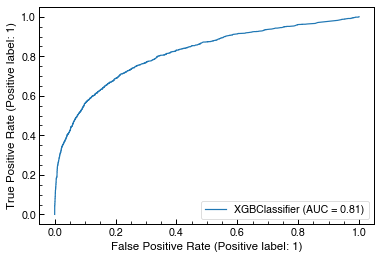

In [76]:
metrics.plot_roc_curve(mdl, X_test, Y_test)

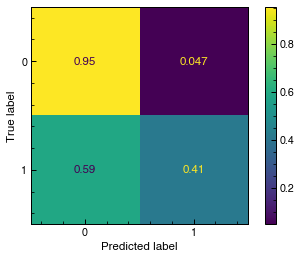

In [77]:
metrics.plot_confusion_matrix(mdl, X_test, Y_test, normalize='true')

In [78]:
if hasattr(mdl, "predict_proba"):
    prob_pos = mdl.predict_proba(X_test)[:, 1]
#     prob_pos = 10**(mdl.predict_log_proba(X_test)[:,1])
else:  # use decision function
    prob_pos = mdl.decision_function(X_test)
    prob_pos = \
        (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

fraction_of_positives, mean_predicted_value = \
        calibration_curve(Y_test, prob_pos, n_bins=10)

Text(0.5, 0, 'Mean predicted value')

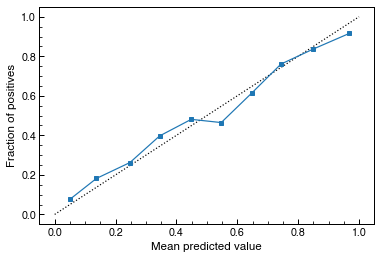

In [79]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax.plot(mean_predicted_value, fraction_of_positives, "s-")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")

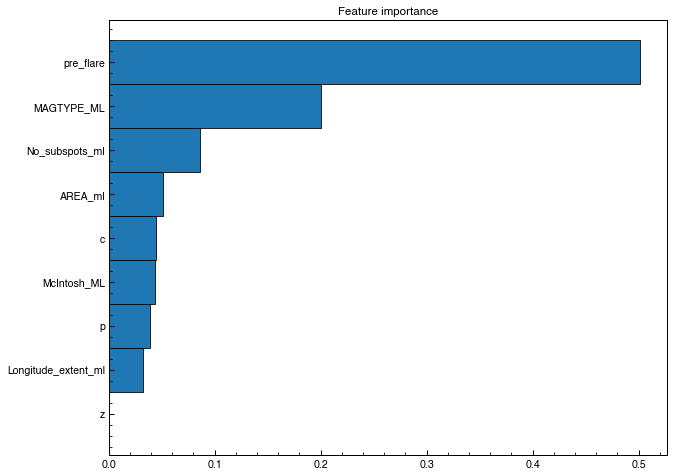

In [80]:
plot_feature_importance(mdl, features)